In [ ]:
#Importing the libraries
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
from nltk.corpus import brown
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os

In [ ]:
from nltk.corpus import nps_chat as nps
nltk.download('nps_chat')
nltk.download('punkt')

[nltk_data] Downloading package nps_chat to /root/nltk_data...
[nltk_data]   Unzipping corpora/nps_chat.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def get_dialogue_data(output_file):
    open(output_file, 'w').close();
    tagged_sents=brown.tagged_sents()
    with open(output_file,'a') as fileWrite:
        for sentence in tagged_sents:
            for tuple_word in sentence:
                fileWrite.write(tuple_word[0]+'\t'+tuple_word[1])
                fileWrite.write('\n')
                fileWrite.write('\n')
                fileWrite.write('\n')

def get_sentence_data(output_file):
    open(output_file,'w').close();
    sentences=brown.sents()
    with open(output_file,'a') as fileWrite:
        for eachSentence in sentences:
            fileWrite.write(' '.join(eachSentence))
            fileWrite.write('\n')


def get_dialogue_data(output_file):
    open(output_file,'w').close();
    posts=nps.xml_posts()
    with open(output_file,'a') as fileWrite:
        for eachPost in posts:
            fileWrite.write(eachPost.get('class').lower()+'\t'+eachPost.text)
            fileWrite.write('\n')

In [ ]:
print("preparing module")
data_folder='/content/dialogue'
output_file='test.txt'
get_dialogue_data(data_folder+'/'+output_file)
output_file='data.txt'
get_dialogue_data(data_folder+'/'+output_file)

preparing module


In [ ]:
#Representing the each row of the input as a sequence of word indices.
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
ftrain = open(os.path.join("/content/dialogue", "data.txt"), 'rb')
for line in ftrain:
    label, sentence = line.strip().split(b"\t")
    words = nltk.word_tokenize(sentence.decode("ascii", "ignore").lower())
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
    num_recs += 1
ftrain.close()
#print(len(word_freqs))

In [ ]:
MAX_FEATURES = 6000 
MAX_SENTENCE_LENGTH = 40
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in
enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}

In [ ]:
#Building the Data
labels=[]
file_name="data.txt"
file_path="/content/dialogue"
with open(os.path.join(file_path,file_name),'r') as fileRead:
    for line in fileRead:
        l=line.split("\t")
        #print(l[0])
        labels.append(l[0])
label_set_list=list(set(labels))
nos_labels=len(label_set_list)

In [ ]:
#Building the data sets to feed to the network and converting the input sentences to into a word sequence.
X = np.empty((num_recs, ), dtype=list)
y = np.zeros((num_recs, nos_labels))
i = 0
ftrain = open(os.path.join("/content/dialogue", "data.txt"), 'rb')
for line in ftrain:
    label, sentence = line.strip().split(b"\t")
    words = nltk.word_tokenize(sentence.decode("ascii", "ignore").lower())
    label=label.decode("ascii","ignore").lower()
    seqs = []
    dummy_vec=[0]*nos_labels
    for word in words:
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    X[i] = seqs
    dummy_vec[label_set_list.index(label)]=1
    y[i]=dummy_vec
    i+=1
    
ftrain.close()
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

In [ ]:
#Splitting the Data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Defining the model
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 100
BATCH_SIZE = 32
NUM_EPOCHS = 7
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE,input_length=MAX_SENTENCE_LENGTH))
model.add(Bidirectional(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2)))
#model.add(dropout=0.2)
model.add(Dense(nos_labels, activation = "softmax") )
#model.add(Activation("softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy"])

In [ ]:

#Modelling the data
history = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_data=(Xtest, ytest))

Epoch 1/7
265/265 [==============================] - 80s 280ms/step - loss: 1.7832 - accuracy: 0.4432 - val_loss: 0.8415 - val_accuracy: 0.7611
Epoch 2/7
265/265 [==============================] - 73s 275ms/step - loss: 0.7137 - accuracy: 0.8027 - val_loss: 0.6925 - val_accuracy: 0.8122
Epoch 3/7
265/265 [==============================] - 73s 274ms/step - loss: 0.4804 - accuracy: 0.8695 - val_loss: 0.6297 - val_accuracy: 0.8273
Epoch 4/7
265/265 [==============================] - 72s 272ms/step - loss: 0.3518 - accuracy: 0.8954 - val_loss: 0.6763 - val_accuracy: 0.8169
Epoch 5/7
265/265 [==============================] - 73s 274ms/step - loss: 0.2406 - accuracy: 0.9308 - val_loss: 0.6610 - val_accuracy: 0.8207
Epoch 6/7
265/265 [==============================] - 72s 273ms/step - loss: 0.1926 - accuracy: 0.9456 - val_loss: 0.7647 - val_accuracy: 0.8108
Epoch 7/7
265/265 [==============================] - 72s 272ms/step - loss: 0.1543 - accuracy: 0.9566 - val_loss: 0.8270 - val_accuracy:

In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from textblob import TextBlob

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
           

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [84]:
for dirname, _, filenames in os.walk('/content/dialogue'):
    
    dff = {"Transcript":[],
           "Total_Dialogues":[],
           "Positive_Dialogues":[],
           "Neutral_Dialogues":[],
           "Negative_Dialogues":[],
           "Positive_Sentiment":[],
           "Neutral_Sentiment":[],
           "Negative_Sentiment":[]}
    df = pd.DataFrame(dff)
    
    for filename in filenames:
        print(filename)
        
        fname = os.path.join(dirname, filename)
        with open(fname,'r',encoding="utf-8") as f:
            raw_data = f.read()
            data = TextBlob(raw_data)
            pos = []
            neu = []
            neg = []
            for sentence in data.sentences:
                pol = sentence.sentiment.polarity
                if pol > 0.25:
                    pos.append(pol)
                elif pol > -0.25 and pol <= 0.25:
                    neu.append(pol)
                else:
                    neg.append(pol)
                
            total = len(data.sentences)
                
            pos_t = len(pos)
            neu_t = len(neu)
            neg_t = len(neg)
                
            pos_avg = sum(pos)/pos_t
            neu_avg = sum(neu)/neu_t
            neg_avg = sum(neg)/neg_t
                
            df = df.append({"Transcript":filename[:-4],
                            "Total_Dialogues":total,
                            "Positive_Dialogues":pos_t,
                            "Neutral_Dialogues":neu_t,
                            "Negative_Dialogues":neg_t,
                            "Positive_Sentiment":pos_avg,
                            "Neutral_Sentiment":neu_avg,
                            "Negative_Sentiment":neg_avg}, ignore_index=True)

19.txt
22.txt
7.txt
4.txt
23.txt
0.txt
29.txt
1.txt
18.txt
14.txt
3.txt
20.txt
17.txt
25.txt
2.txt
9.txt
24.txt
10.txt
12.txt
13.txt
26.txt
5.txt


ZeroDivisionError: ignored

In [85]:
df.head()

,Transcript,Total_Dialogues,Positive_Dialogues,Neutral_Dialogues,Negative_Dialogues,Positive_Sentiment,Neutral_Sentiment,Negative_Sentiment
0,19,69.0,19.0,47.0,3.0,0.474875,0.040898,-0.454167
1,22,245.0,61.0,176.0,8.0,0.453825,0.011102,-0.434375
2,7,66.0,19.0,40.0,7.0,0.426115,0.018338,-0.319337
3,4,165.0,21.0,133.0,11.0,0.493005,0.001903,-0.472908
4,23,132.0,35.0,84.0,13.0,0.485703,0.003631,-0.448237


In [86]:
import seaborn as sns
import matplotlib.pyplot as plt


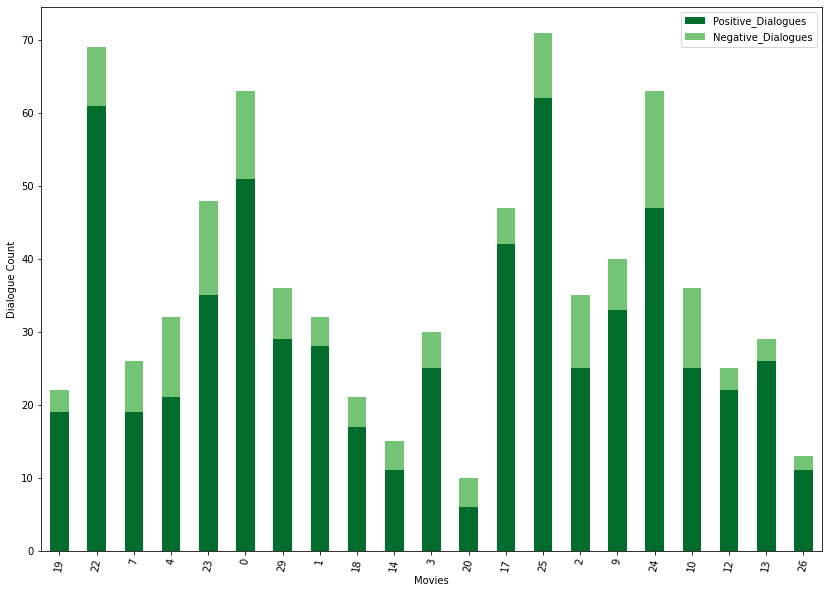

In [87]:
colors = ["#006D2C","#74C476"]
ax = df.loc[:,['Positive_Dialogues','Negative_Dialogues']].plot.bar(stacked=True, color=colors,figsize=(14, 10))
ax.set_xticklabels(df.Transcript,rotation=80)
ax.set_xlabel("Movies")
ax.set_ylabel("Dialogue Count")
plt.show()